### Importing Python Libraries

In [10]:
%matplotlib inline
import torch
from torch import nn
from torch.nn import functional as F
import torchvision
from torchvision import transforms
from torch.utils.data import random_split

import matplotlib.pyplot as plt
from IPython.display import clear_output

from statistics import mean
import random
import time

### Loading the Mnist Dataset

In [11]:
def dataset_load(root="../mnist_project/data"):    
    train_data = torchvision.datasets.MNIST(root=root, train=True, transform=transforms.ToTensor(), download=False)
    test_tens = torchvision.datasets.MNIST(root=root, train=False, transform=transforms.ToTensor(), download=False)
    
    train_tens, val_tens = random_split(train_data, [50000, 10000], generator=torch.Generator().manual_seed(42))
    return train_tens, val_tens, test_tens

In [12]:
train_tensor, val_tensor, test_tensor = dataset_load()

### Lengths of our subsets

In [13]:
len(train_tensor), len(val_tensor), len(test_tensor)

(50000, 10000, 10000)

### Random sample shape - 28x28 picture

In [14]:
train_tensor[0][0].shape, train_tensor[0][1]

(torch.Size([1, 28, 28]), 6)

### Iterating and Visualizing the dataset

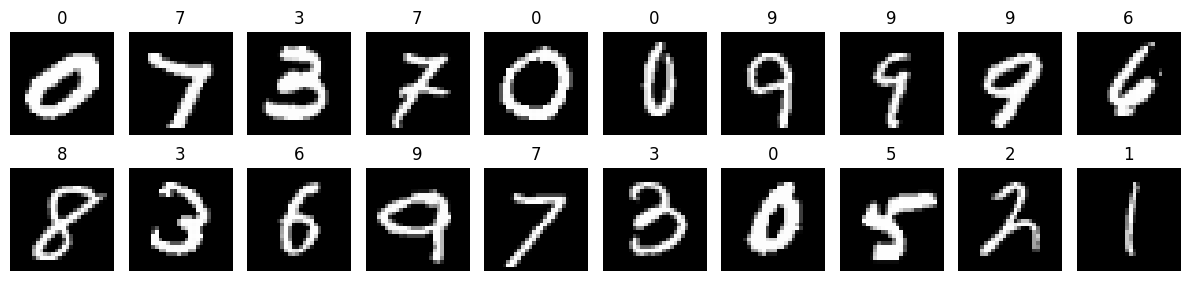

In [15]:
rand_idx = random.sample(range(0, len(train_tensor)), 20)

figure = plt.figure(figsize=(12, 3), tight_layout=True)

for i in range(len(rand_idx)):
    img, label = train_tensor[rand_idx[i]]
    figure.add_subplot(2, 10, i+1)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## Easiest Linear Classification Model
##

### Data loaders

In [57]:
def data_loader(data, is_train, batch_size):
    return torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=is_train, num_workers=1)

In [17]:
def test_loader(data, batch_size):
    return torch.utils.data.DataLoader(data, batch_size=batch_size)

### Testing loaders

In [58]:
tic = time.time()
for X, y in data_loader(train_tensor, True, 256):
    continue
f'{time.time() - tic:.2f} sec'

'2.86 sec'

In [19]:
X_1, y_1 = next(iter(data_loader(train_tensor, True, 64)))
print("Shapes:", X_1.shape, X_1.dtype, y_1.shape, y_1.dtype, '\n')
print(y_1, '\n')
print(X_1.min(), X_1.max())

Shapes: torch.Size([64, 1, 28, 28]) torch.float32 torch.Size([64]) torch.int64 

tensor([9, 4, 7, 1, 6, 2, 3, 0, 6, 9, 3, 7, 6, 3, 1, 6, 2, 9, 7, 1, 6, 6, 7, 5,
        2, 4, 4, 1, 6, 5, 3, 3, 4, 2, 5, 5, 0, 9, 1, 6, 3, 1, 6, 1, 1, 6, 3, 0,
        7, 4, 3, 6, 2, 3, 8, 3, 9, 4, 5, 3, 8, 2, 1, 3]) 

tensor(0.) tensor(1.)


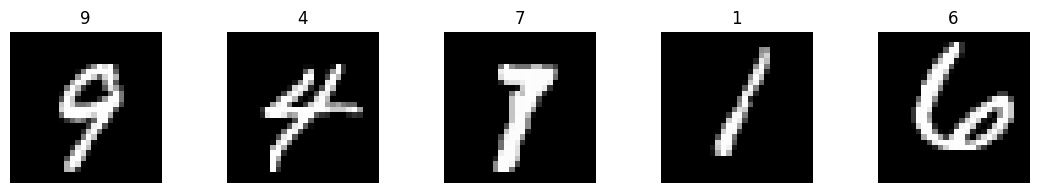

In [20]:
rand_idx = random.sample(range(0, 64), 5)
figure = plt.figure(figsize=(11, 2), tight_layout=True)
for i in range(len(rand_idx)):
    img, label = X_1[i], y_1[i]
    figure.add_subplot(1, 5, i+1)
    plt.title(label.item())
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

### Baseline Model

In [59]:
class BaseModel(nn.Module):
    def __init__(self, lr, num_outputs):
        super().__init__()
        self.lr = lr
        self.num_outputs = num_outputs
        self.net = nn.Sequential(nn.Flatten(), nn.LazyLinear(self.num_outputs))

    def forward(self, X):
        return self.net(X)

    def ce_loss(self, Y_hat, Y):
        return F.cross_entropy(Y_hat, Y, reduction='mean')

    def config_optim(self):
        return torch.optim.SGD(self.parameters(), lr=self.lr)

    def batch_step(self, batch):
        l = self.ce_loss(self.forward(batch[0]), batch[1])
        return l

In [98]:
class Plotter():
    def __init__(self, title):
        self.title = title

    def plot(self, train_losses, val_losses):
        clear_output(wait=True) 
        epochs = range(1, len(train_losses) + 1)
        plt.figure(figsize=(8,5))
        plt.plot(epochs, train_losses, label=f"Train loss: {train_losses[-1]:.4f}")
        plt.plot(epochs, val_losses, label=f"Val loss: {val_losses[-1]:.4f}")
        plt.xlabel("Epoch")
        plt.title(self.title)
        plt.legend()
        plt.show()

In [96]:
class BaseTrainer():
    def __init__(self, num_epochs):
        self.num_epochs = num_epochs

    def prepare_data(self, train_data, val_data):
        self.train_dataloader = data_loader(train_data, True, 256)
        self.val_dataloader = data_loader(val_data, False, 256)
        self.num_train_batches = len(self.train_dataloader)
        self.val_train_batches = len(self.val_dataloader)
        self.train_data = train_data
        self.val_data = val_data
        
    def fit(self, model, train_data, val_data, plotter):
        self.prepare_data(train_data, val_data)
        model.trainer = self
        self.model = model
        self.optim = model.config_optim()
        self.plotter = plotter
        self.train_losses_epoch = []
        self.val_losses_epoch = []
        self.epoch = 0
        for self.epoch in range(self.num_epochs):
            self.fit_epoch()
            self.plotter.plot(self.train_losses_epoch, self.val_losses_epoch)

    def fit_epoch(self):
        train_losses_batch = []
        val_losses_batch = []
        
        self.model.train()
        for batch in self.train_dataloader:
            loss = self.model.batch_step(batch)
            self.optim.zero_grad()
            loss.backward()
            self.optim.step()
            train_losses_batch.append(loss.item())
            
        self.model.eval()
        for batch in self.val_dataloader:
            with torch.no_grad():
                l = self.model.batch_step(batch)
                val_losses_batch.append(l.item())
                
        self.train_losses_epoch.append(mean(train_losses_batch))
        self.val_losses_epoch.append(mean(val_losses_batch))        

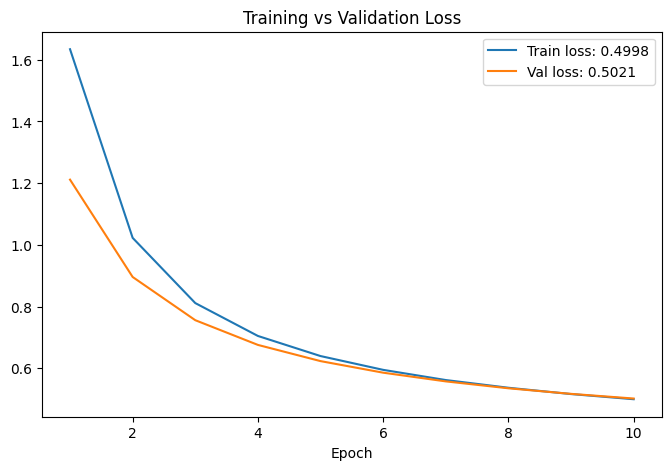

In [97]:
base_model = BaseModel(0.01, 10)
plotter = Plotter("Base Model Train/val loss")
base_trainer = BaseTrainer(10)
base_trainer.fit(base_model, train_tensor, val_tensor, plotter)